In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
import os
from tqdm import tqdm
import seaborn as sns



In [2]:
# Configure GPU memory growth to prevent OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configuration successful. Available GPUs: {len(gpus)}")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found, using CPU")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

GPU configuration successful. Available GPUs: 1
Libraries imported successfully!


In [3]:
# Dataset paths - Update these paths according to your setup
train_path = '/content/drive/MyDrive/datasetsHandwriting/emnist_Balanced/emnist-balanced-train.csv'
test_path = '/content/drive/MyDrive/datasetsHandwriting/emnist_Balanced/emnist-balanced-test.csv'
model_save_path = '/content/drive/MyDrive/models/emnist_balanced_cnn_best.h5'

# Create model directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Configuration parameters
BATCH_SIZE = 64
IMG_HEIGHT = 28
IMG_WIDTH = 28
CHANNELS = 1
MAX_SAMPLES_FOR_EXPLORATION = 10000  # For data exploration

print("Configuration set successfully!")

Configuration set successfully!


In [4]:
# Get basic information about the dataset
print("=== EMNIST Dataset Information ===")

# Read first few rows to understand structure
sample_data = pd.read_csv(train_path, nrows=5)
print(f"Dataset columns: {len(sample_data.columns)}")
print(f"First column (label): {sample_data.columns[0]}")
print(f"Pixel columns: {sample_data.columns[1:6].tolist()}... (showing first 5)")


=== EMNIST Dataset Information ===
Dataset columns: 785
First column (label): 45
Pixel columns: ['0', '0.1', '0.2', '0.3', '0.4']... (showing first 5)


In [5]:

# Count total rows efficiently
def count_rows(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in f) - 1  # -1 for header

train_samples = count_rows(train_path)
test_samples = count_rows(test_path)

print(f"\nDataset Statistics:")
print(f"Training samples: {train_samples:,}")
print(f"Test samples: {test_samples:,}")
print(f"Total samples: {train_samples + test_samples:,}")
print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH} pixels")


Dataset Statistics:
Training samples: 112,799
Test samples: 18,799
Total samples: 131,598
Image dimensions: 28x28 pixels


In [6]:
# Load a sample of data for exploration
print("Loading sample data for exploration...")
sample_size = min(MAX_SAMPLES_FOR_EXPLORATION, train_samples)
sample_df = pd.read_csv(train_path, nrows=sample_size)

# Separate labels and pixel data
labels = sample_df.iloc[:, 0].values
pixel_data = sample_df.iloc[:, 1:].values

print(f"Loaded {len(sample_df)} samples for exploration")
print(f"Pixel data shape: {pixel_data.shape}")
print(f"Labels shape: {labels.shape}")

# Basic statistics
print(f"\nPixel Value Statistics:")
print(f"Min pixel value: {pixel_data.min()}")
print(f"Max pixel value: {pixel_data.max()}")
print(f"Mean pixel value: {pixel_data.mean():.2f}")
print(f"Standard deviation: {pixel_data.std():.2f}")

Loading sample data for exploration...
Loaded 10000 samples for exploration
Pixel data shape: (10000, 784)
Labels shape: (10000,)

Pixel Value Statistics:
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 44.70
Standard deviation: 84.99


In [7]:
# Analyze label distribution
unique_labels = np.unique(labels)
label_counts = pd.Series(labels).value_counts().sort_index()

print(f"=== Label Analysis ===")
print(f"Number of unique classes: {len(unique_labels)}")
print(f"Label range: {unique_labels.min()} to {unique_labels.max()}")


=== Label Analysis ===
Number of unique classes: 47
Label range: 0 to 46


In [8]:

def get_character_from_label(label):
    """
    Convert EMNIST label to character based on a custom explicit mapping for a subset of lowercase letters,
    while using generalizable ASCII arithmetic for digits and uppercase letters.
    """
    custom_lowercase_map = {
        36: 'a',
        37: 'b',
        38: 'd',
        39: 'e',
        40: 'f',
        41: 'g',
        42: 'h',
        43: 'n',
        44: 'q',
        45: 'r',
        46: 't'
    }

    if 0 <= label <= 9:
        return chr(ord('0') + label)
    elif 10 <= label <= 35:
        return chr(ord('A') + label - 10)
    elif 36 <= label <= 46:
        if label in custom_lowercase_map:
            return custom_lowercase_map[label]
        else:
            return f"UnknownInCustomLower({label})"
    else:
        return f"Unknown({label})"


In [9]:

# Create character mapping
label_to_char = {label: get_character_from_label(label) for label in unique_labels}
print(f"\nSample character mappings:")
for i, (label, char) in enumerate(list(label_to_char.items())[:10]):
    print(f"Label {label}: '{char}'")
print("...")


Sample character mappings:
Label 0: '0'
Label 1: '1'
Label 2: '2'
Label 3: '3'
Label 4: '4'
Label 5: '5'
Label 6: '6'
Label 7: '7'
Label 8: '8'
Label 9: '9'
...


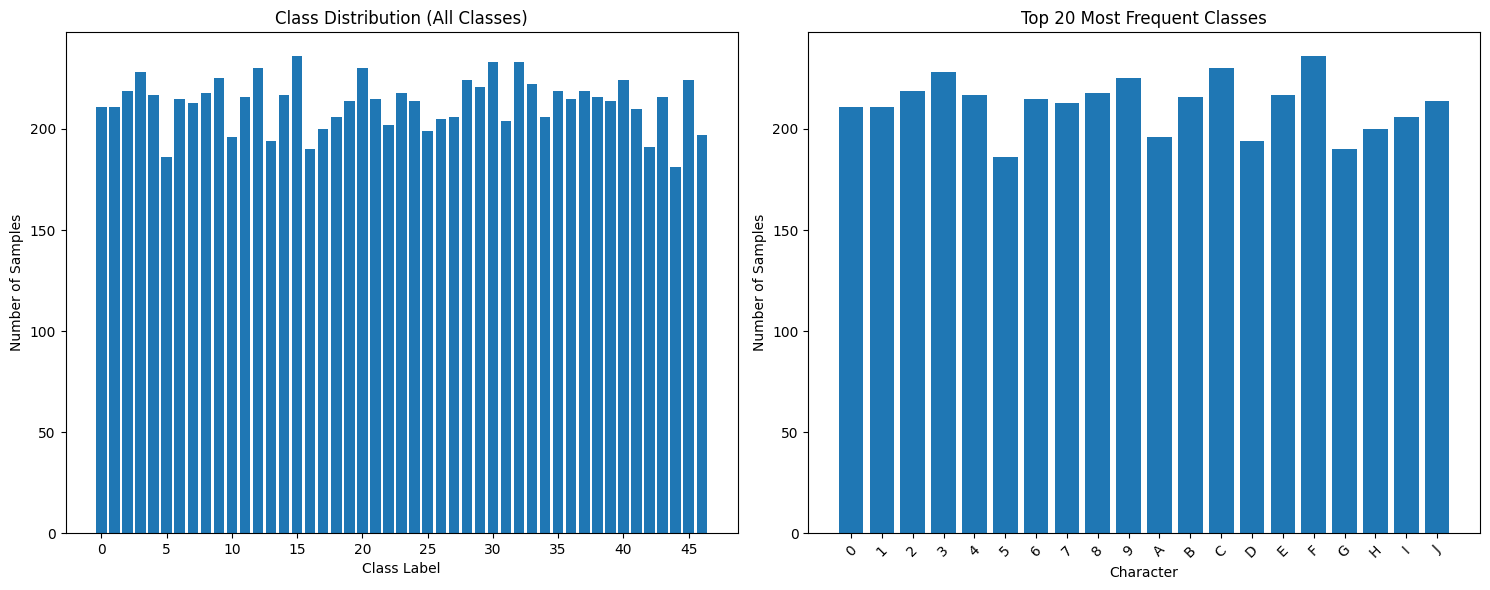


Class distribution statistics:
Most frequent class: 0 ('0') with 211 samples
Least frequent class: 46 ('t') with 197 samples
Average samples per class: 212.8


In [10]:


# Display label distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(label_counts)), label_counts.values)
plt.title('Class Distribution (All Classes)')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(range(0, len(label_counts), 5))

plt.subplot(1, 2, 2)
# Show top 20 most frequent classes
top_20 = label_counts.head(20)
chars = [label_to_char[label] for label in top_20.index]
plt.bar(range(len(top_20)), top_20.values)
plt.title('Top 20 Most Frequent Classes')
plt.xlabel('Character')
plt.ylabel('Number of Samples')
plt.xticks(range(len(top_20)), chars, rotation=45)

plt.tight_layout()
plt.show()

print(f"\nClass distribution statistics:")
print(f"Most frequent class: {label_counts.index[0]} ('{label_to_char[label_counts.index[0]]}') with {label_counts.iloc[0]} samples")
print(f"Least frequent class: {label_counts.index[-1]} ('{label_to_char[label_counts.index[-1]]}') with {label_counts.iloc[-1]} samples")
print(f"Average samples per class: {label_counts.mean():.1f}")

=== Sample Images from Dataset ===


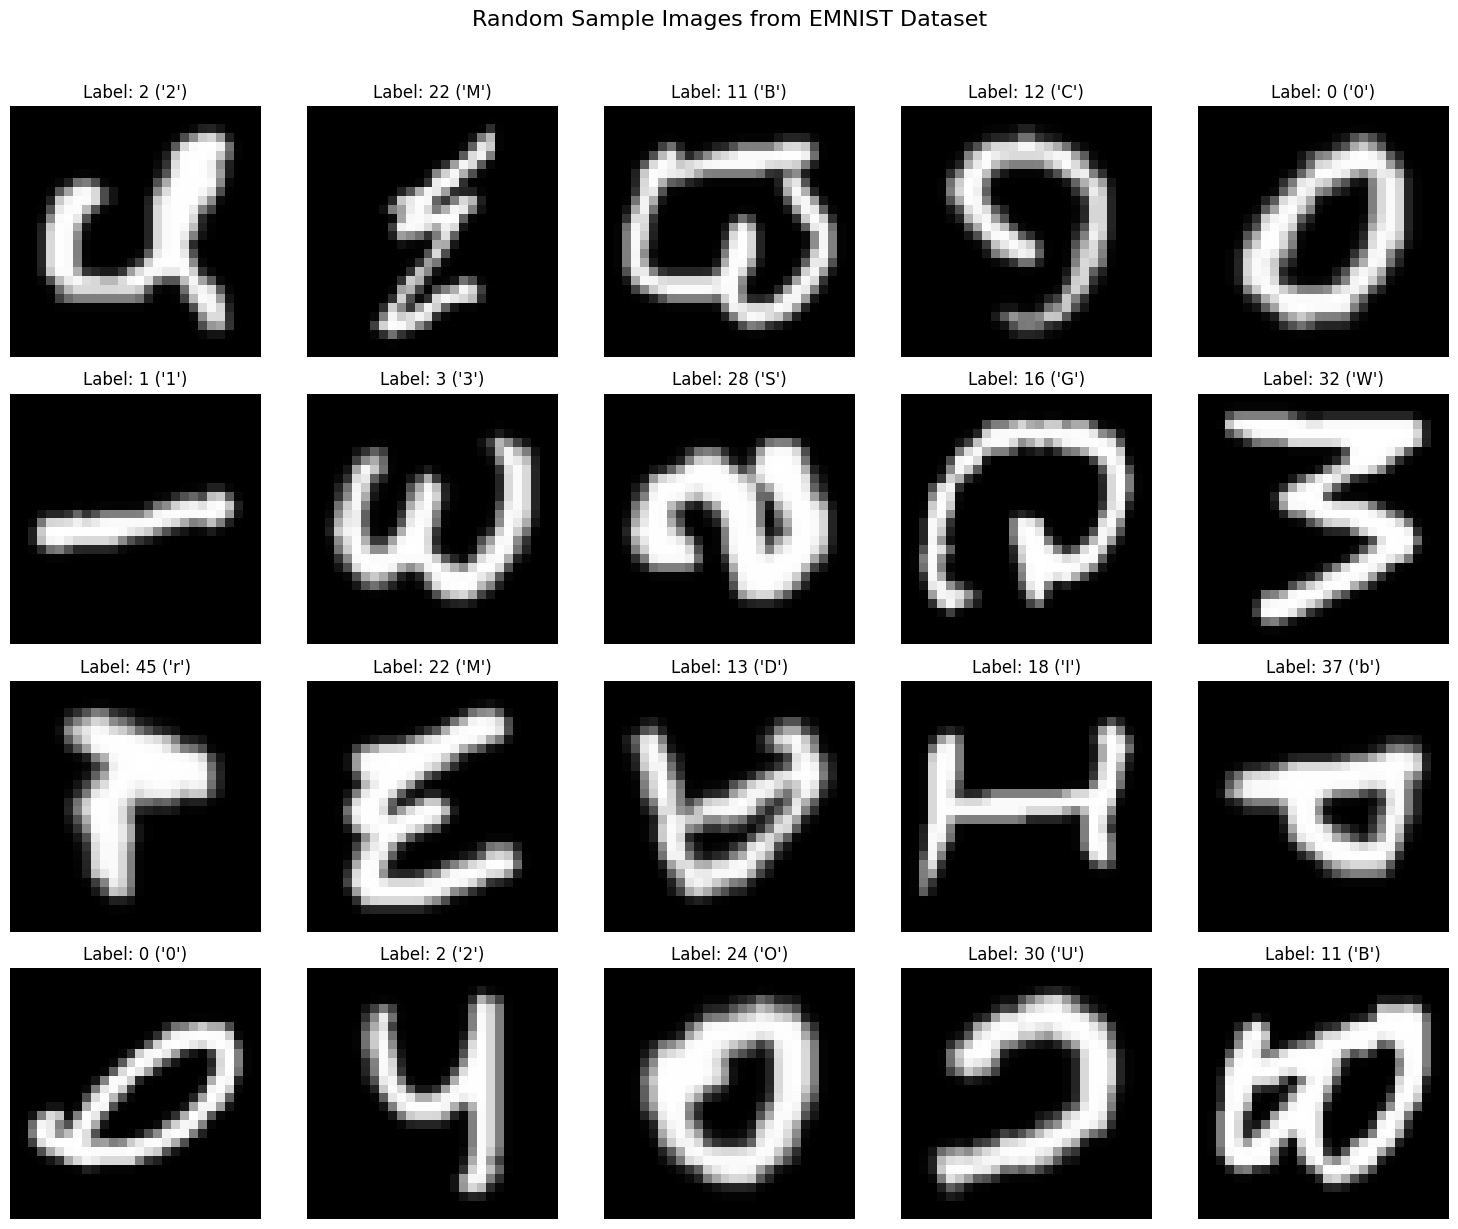

In [11]:
# Function to display sample images
def display_sample_images(pixel_data, labels, label_to_char, n_samples=20, cols=5):
    """Display sample images from the dataset"""
    rows = (n_samples + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    # Get random indices
    indices = np.random.choice(len(pixel_data), n_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)

        # Reshape pixel data to image
        image = pixel_data[idx].reshape(IMG_HEIGHT, IMG_WIDTH)

        # Display image
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[idx]} ('{label_to_char[labels[idx]]}')")
        plt.axis('off')

    plt.suptitle('Random Sample Images from EMNIST Dataset', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Display sample images
print("=== Sample Images from Dataset ===")
display_sample_images(pixel_data, labels, label_to_char, n_samples=20)


=== Digits (0-9) ===


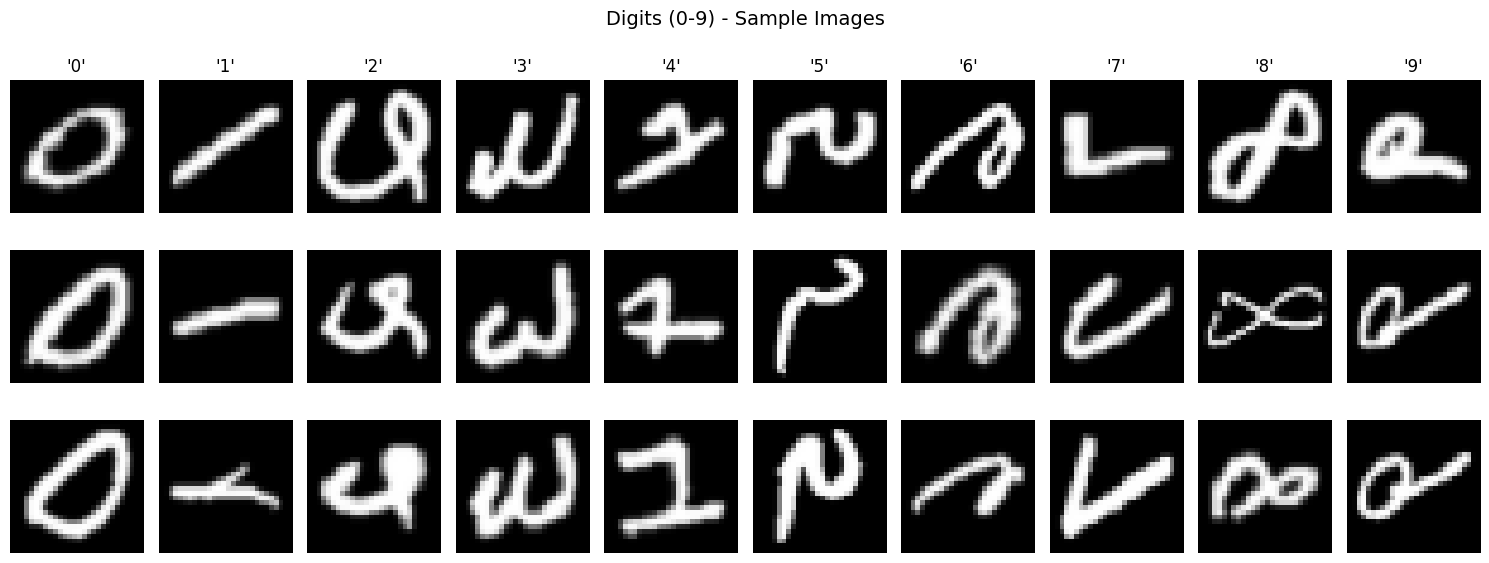


=== Uppercase (A-J) ===


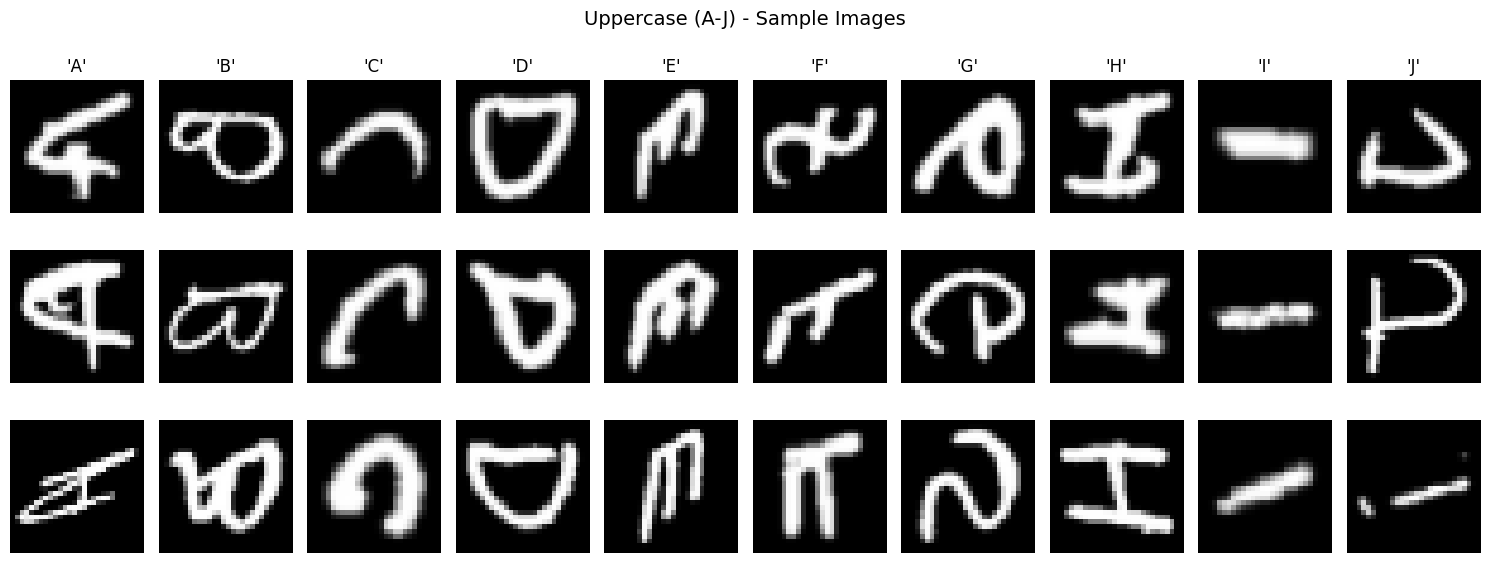


=== Lowercase (a-j) ===


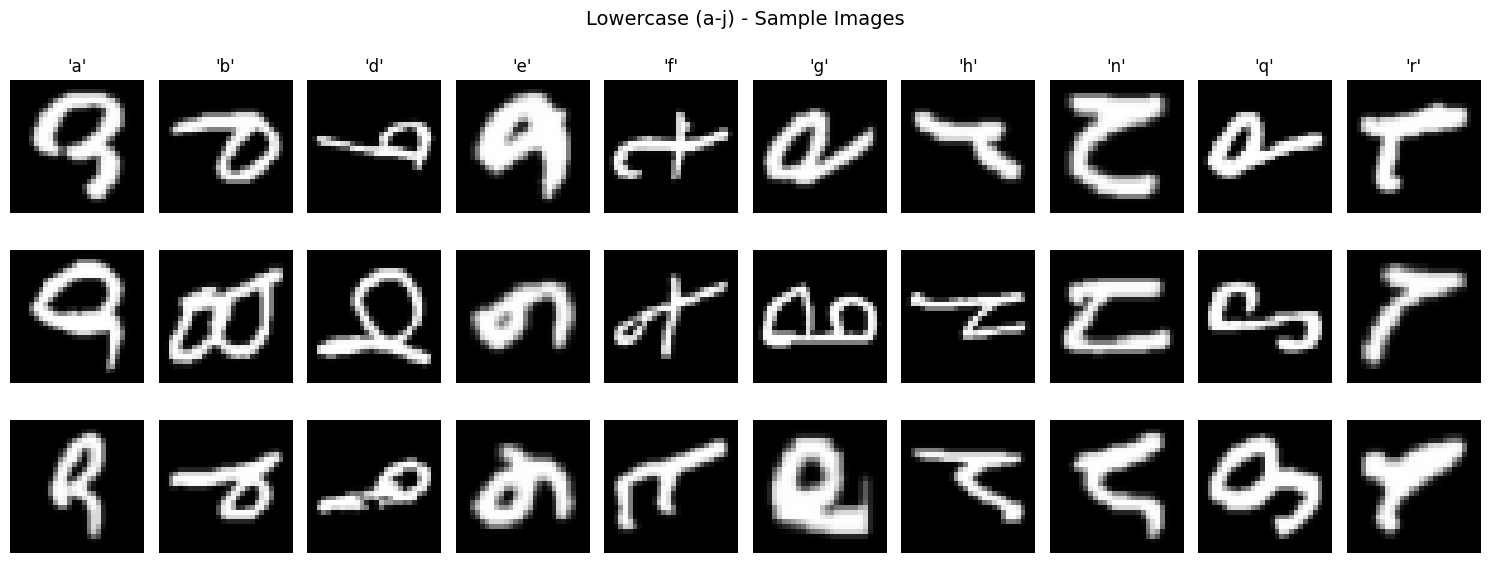

In [12]:
# Display images organized by character type
def display_by_category(pixel_data, labels, label_to_char, samples_per_category=5):
    """Display images organized by digits, uppercase, and lowercase"""

    # Categorize labels
    digits = [i for i in range(10) if i in labels]
    uppercase = [i for i in range(10, 36) if i in labels]
    lowercase = [i for i in range(36, 47) if i in labels]

    categories = [
        ("Digits (0-9)", digits[:10]),
        ("Uppercase (A-J)", uppercase[:10]),
        ("Lowercase (a-j)", lowercase[:10])
    ]

    for category_name, category_labels in categories:
        print(f"\n=== {category_name} ===")

        plt.figure(figsize=(15, 6))

        for i, label in enumerate(category_labels):
            # Find samples with this label
            label_indices = np.where(labels == label)[0]
            if len(label_indices) == 0:
                continue

            # Get random samples for this label
            n_samples = min(samples_per_category, len(label_indices))
            sample_indices = np.random.choice(label_indices, n_samples, replace=False)

            for j, idx in enumerate(sample_indices):
                plt.subplot(samples_per_category, len(category_labels), j * len(category_labels) + i + 1)

                image = pixel_data[idx].reshape(IMG_HEIGHT, IMG_WIDTH)
                plt.imshow(image, cmap='gray')

                if j == 0:  # Only show title on first row
                    plt.title(f"'{label_to_char[label]}'")
                plt.axis('off')

        plt.suptitle(f'{category_name} - Sample Images', fontsize=14)
        plt.tight_layout()
        plt.show()

# Display by category
display_by_category(pixel_data, labels, label_to_char, samples_per_category=3)

=== Image Properties Analysis ===


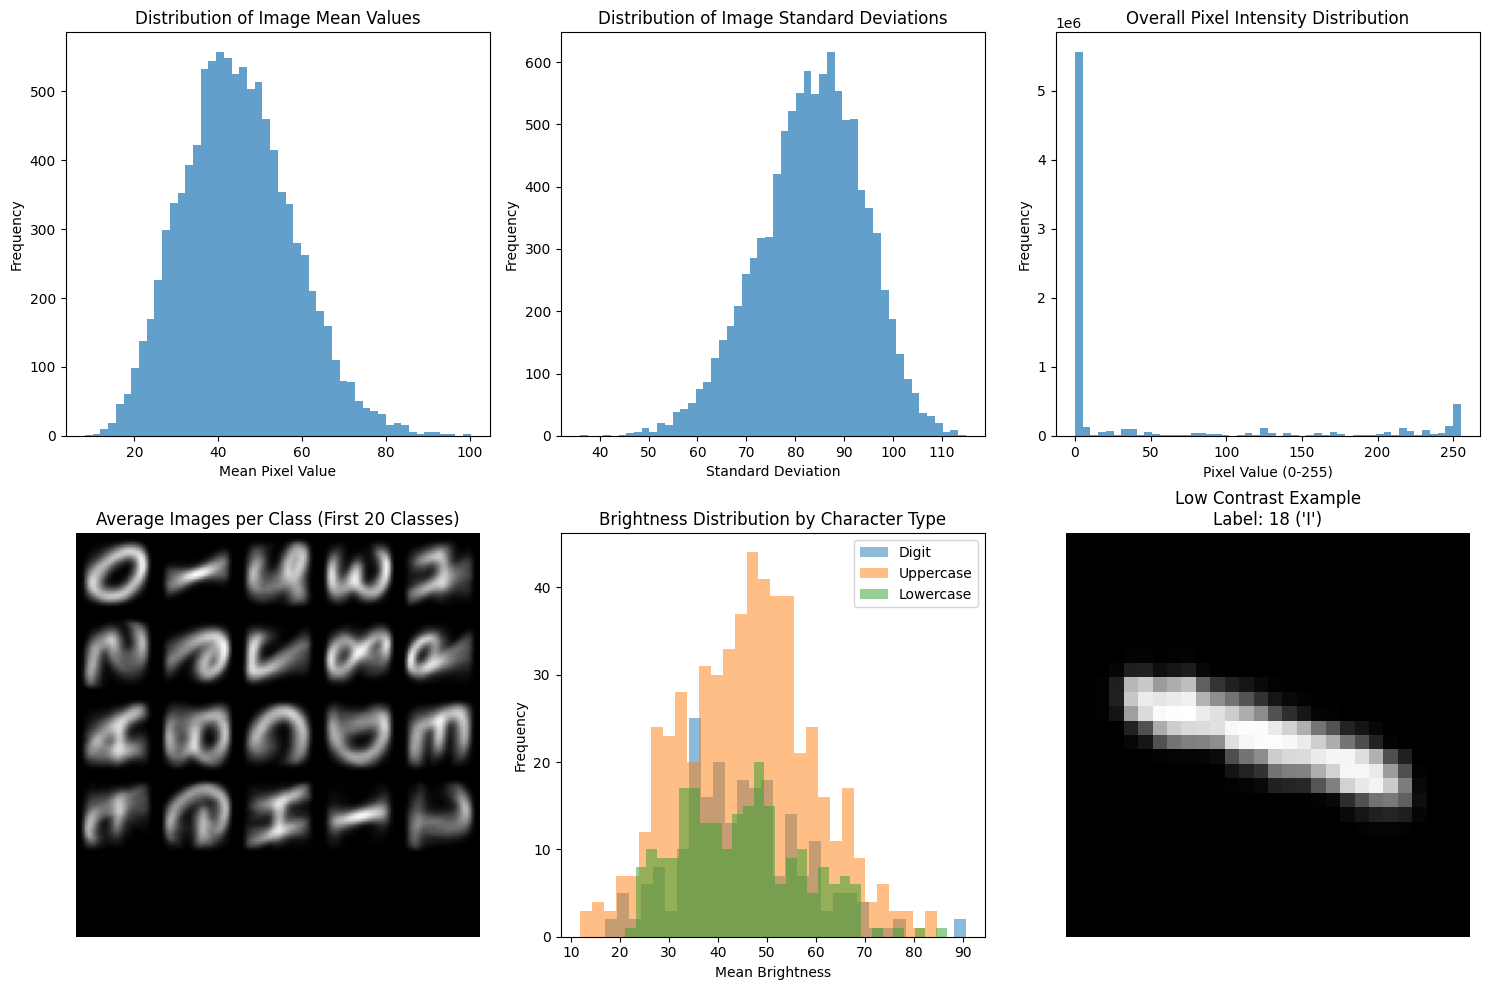

Image statistics:
Average image mean: 44.70
Average image std: 83.28
Images with very low contrast (std < 10): 0
Images with very high contrast (std > 100): 467


In [13]:
# Analyze image properties
print("=== Image Properties Analysis ===")

# Calculate statistics for each image
image_means = np.mean(pixel_data, axis=1)
image_stds = np.std(pixel_data, axis=1)
image_mins = np.min(pixel_data, axis=1)
image_maxs = np.max(pixel_data, axis=1)

# Plot distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(image_means, bins=50, alpha=0.7)
plt.title('Distribution of Image Mean Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(image_stds, bins=50, alpha=0.7)
plt.title('Distribution of Image Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
pixel_intensity_dist = pixel_data.flatten()
plt.hist(pixel_intensity_dist, bins=50, alpha=0.7)
plt.title('Overall Pixel Intensity Distribution')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')

# Average image per class
plt.subplot(2, 3, 4)
avg_images_per_class = []
sample_labels_for_avg = []

for label in sorted(unique_labels)[:20]:  # Show first 20 classes
    label_indices = np.where(labels == label)[0]
    if len(label_indices) > 0:
        avg_image = np.mean(pixel_data[label_indices], axis=0)
        avg_images_per_class.append(avg_image.reshape(IMG_HEIGHT, IMG_WIDTH))
        sample_labels_for_avg.append(label)

# Create a grid of average images
if avg_images_per_class:
    grid_size = int(np.ceil(np.sqrt(len(avg_images_per_class))))
    combined_avg = np.zeros((grid_size * IMG_HEIGHT, grid_size * IMG_WIDTH))

    for i, avg_img in enumerate(avg_images_per_class):
        row = i // grid_size
        col = i % grid_size
        combined_avg[row*IMG_HEIGHT:(row+1)*IMG_HEIGHT,
                     col*IMG_WIDTH:(col+1)*IMG_WIDTH] = avg_img

    plt.imshow(combined_avg, cmap='gray')
    plt.title('Average Images per Class (First 20 Classes)')
    plt.axis('off')

plt.subplot(2, 3, 5)
# Correlation between mean brightness and character type
char_types = []
for label in labels[:1000]:  # Sample for performance
    if 0 <= label <= 9:
        char_types.append('Digit')
    elif 10 <= label <= 35:
        char_types.append('Uppercase')
    elif 36 <= label <= 46:
        char_types.append('Lowercase')
    else:
        char_types.append('Other')

char_type_df = pd.DataFrame({
    'mean_brightness': image_means[:1000],
    'char_type': char_types
})

for char_type in ['Digit', 'Uppercase', 'Lowercase']:
    data = char_type_df[char_type_df['char_type'] == char_type]['mean_brightness']
    if len(data) > 0:
        plt.hist(data, alpha=0.5, label=char_type, bins=30)

plt.xlabel('Mean Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution by Character Type')
plt.legend()

plt.subplot(2, 3, 6)
# Show some challenging cases (low contrast images)
low_contrast_indices = np.where(image_stds < np.percentile(image_stds, 5))[0]
if len(low_contrast_indices) > 0:
    sample_idx = np.random.choice(low_contrast_indices)
    challenging_image = pixel_data[sample_idx].reshape(IMG_HEIGHT, IMG_WIDTH)
    plt.imshow(challenging_image, cmap='gray')
    plt.title(f'Low Contrast Example\nLabel: {labels[sample_idx]} (\'{label_to_char[labels[sample_idx]]}\')')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Image statistics:")
print(f"Average image mean: {np.mean(image_means):.2f}")
print(f"Average image std: {np.mean(image_stds):.2f}")
print(f"Images with very low contrast (std < 10): {np.sum(image_stds < 10)}")
print(f"Images with very high contrast (std > 100): {np.sum(image_stds > 100)}")

In [17]:
# Memory-efficient data loading functions
def create_tf_dataset(file_path, batch_size=32, is_training=True):
    """Create TensorFlow dataset with memory-efficient loading"""

    def parse_csv_line(line):
        # Parse CSV line and extract features and labels
        defaults = [[0.0]] * 785  # 784 pixels + 1 label
        parsed = tf.io.decode_csv(line, defaults)

        # First column is label, rest are pixels
        label = tf.cast(parsed[0], tf.int32)
        pixels = tf.stack(parsed[1:])

        # Reshape to 28x28 and normalize
        image = tf.reshape(pixels, [28, 28, 1])
        image = tf.cast(image, tf.float32) / 255.0

        return image, label

    # Create dataset from CSV file
    dataset = tf.data.TextLineDataset(file_path)
    dataset = dataset.skip(1)  # Skip header
    dataset = dataset.map(parse_csv_line, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
print("Creating TensorFlow datasets...")
train_dataset = create_tf_dataset(train_path, batch_size=BATCH_SIZE, is_training=True)
test_dataset = create_tf_dataset(test_path, batch_size=BATCH_SIZE, is_training=False)

# Verify dataset
print("Verifying dataset structure...")
for images, labels_batch in train_dataset.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels shape: {labels_batch.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Labels data type: {labels_batch.dtype}")
    print(f"Image value range: {tf.reduce_min(images):.3f} to {tf.reduce_max(images):.3f}")

print("Dataset creation successful!")

Creating TensorFlow datasets...
Verifying dataset structure...
Batch image shape: (64, 28, 28, 1)
Batch labels shape: (64,)
Image data type: <dtype: 'float32'>
Labels data type: <dtype: 'int32'>
Image value range: 0.000 to 1.000
Dataset creation successful!


In [15]:
# Build CNN model for character recognition
def build_cnn_model(num_classes, input_shape=(28, 28, 1)):
    """Build optimized CNN architecture"""

    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Global average pooling instead of flatten to reduce parameters
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
num_classes = len(unique_labels)
print(f"Building CNN model for {num_classes} classes...")

model = build_cnn_model(num_classes)

# Compile model
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

print(model.summary())

Building CNN model for 47 classes...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 498,831 (1.90 MB)

 Trainable params: 497,359 (1.90 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


In [16]:
# Setup training callbacks
def get_callbacks(model_save_path):
    """Get training callbacks"""

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ]

    return callbacks

# Create callbacks
callbacks = get_callbacks(model_save_path)
print("Training callbacks configured successfully!")

Training callbacks configured successfully!


In [17]:
# Train the model
print("=== Starting Model Training ===")

# Calculate steps per epoch
steps_per_epoch = max(1, train_samples // BATCH_SIZE)
print(f"Steps per epoch: {steps_per_epoch}")

# Train the model
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

print("Training completed!")

=== Starting Model Training ===
Steps per epoch: 1762
Epoch 1/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3043 - loss: 2.6915 - sparse_top_k_categorical_accuracy: 0.6036
Epoch 1: val_accuracy improved from -inf to 0.82185, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 110s 52ms/step - accuracy: 0.3044 - loss: 2.6909 - sparse_top_k_categorical_accuracy: 0.6038 - val_accuracy: 0.8219 - val_loss: 0.5213 - val_sparse_top_k_categorical_accuracy: 0.9851 - learning_rate: 0.0010
Epoch 2/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 3:33:59 7s/step - accuracy: 0.7097 - loss: 0.6937 - sparse_top_k_categorical_accuracy: 0.9677
Epoch 2: val_accuracy did not improve from 0.82185
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7097 - loss: 0.6937 - sparse_top_k_categorical_accuracy: 0.9677 - val_accuracy: 0.8197 - val_loss: 0.5253 - val_sparse_top_k_categorical_accuracy: 0.9849 - learning_rate: 0.0010
Epoch 3/30
1759/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7563 - loss: 0.7297 - sparse_top_k_categorical_accuracy: 0.9766
Epoch 3: val_accuracy improved from 0.82185 to 0.84233, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.7563 - loss: 0.7296 - sparse_top_k_categorical_accuracy: 0.9767 - val_accuracy: 0.8423 - val_loss: 0.4480 - val_sparse_top_k_categorical_accuracy: 0.9911 - learning_rate: 0.0010
Epoch 4/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8387 - loss: 0.7077 - sparse_top_k_categorical_accuracy: 0.9677
Epoch 4: val_accuracy improved from 0.84233 to 0.84372, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8387 - loss: 0.7077 - sparse_top_k_categorical_accuracy: 0.9677 - val_accuracy: 0.8437 - val_loss: 0.4428 - val_sparse_top_k_categorical_accuracy: 0.9912 - learning_rate: 0.0010
Epoch 5/30
1759/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8022 - loss: 0.5861 - sparse_top_k_categorical_accuracy: 0.9841
Epoch 5: val_accuracy improved from 0.84372 to 0.86930, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 148s 49ms/step - accuracy: 0.8022 - loss: 0.5861 - sparse_top_k_categorical_accuracy: 0.9841 - val_accuracy: 0.8693 - val_loss: 0.3819 - val_sparse_top_k_categorical_accuracy: 0.9923 - learning_rate: 0.0010
Epoch 6/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8065 - loss: 0.6259 - sparse_top_k_categorical_accuracy: 0.9677
Epoch 6: val_accuracy did not improve from 0.86930
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8065 - loss: 0.6259 - sparse_top_k_categorical_accuracy: 0.9677 - val_accuracy: 0.8684 - val_loss: 0.3814 - val_sparse_top_k_categorical_accuracy: 0.9921 - learning_rate: 0.0010
Epoch 7/30
1758/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8218 - loss: 0.5283 - sparse_top_k_categorical_accuracy: 0.9867
Epoch 7: val_accuracy did not improve from 0.86930
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.8218 - loss: 0.5282 - sparse_top_k_categorical_accuracy: 0.9867 - val_accuracy: 0.8565 - val_loss

1762/1762 ━━━━━━━━━━━━━━━━━━━━ 119s 51ms/step - accuracy: 0.8310 - loss: 0.4900 - sparse_top_k_categorical_accuracy: 0.9884 - val_accuracy: 0.8739 - val_loss: 0.3528 - val_sparse_top_k_categorical_accuracy: 0.9943 - learning_rate: 0.0010
Epoch 10/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8065 - loss: 0.3543 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.87388 to 0.87451, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8065 - loss: 0.3543 - sparse_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8745 - val_loss: 0.3528 - val_sparse_top_k_categorical_accuracy: 0.9942 - learning_rate: 0.0010
Epoch 11/30
1760/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8424 - loss: 0.4640 - sparse_top_k_categorical_accuracy: 0.9898
Epoch 11: val_accuracy did not improve from 0.87451
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.8424 - loss: 0.4640 - sparse_top_k_categorical_accuracy: 0.9898 - val_accuracy: 0.8741 - val_loss: 0.3491 - val_sparse_top_k_categorical_accuracy: 0.9952 - learning_rate: 0.0010
Epoch 12/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9032 - loss: 0.1714 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.87451
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9032 - loss: 0.1714 - sparse_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8743 - val_los

1762/1762 ━━━━━━━━━━━━━━━━━━━━ 144s 77ms/step - accuracy: 0.8471 - loss: 0.4527 - sparse_top_k_categorical_accuracy: 0.9901 - val_accuracy: 0.8805 - val_loss: 0.3364 - val_sparse_top_k_categorical_accuracy: 0.9952 - learning_rate: 0.0010
Epoch 14/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8065 - loss: 0.5093 - sparse_top_k_categorical_accuracy: 0.9677
Epoch 14: val_accuracy did not improve from 0.88047
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8065 - loss: 0.5093 - sparse_top_k_categorical_accuracy: 0.9677 - val_accuracy: 0.8794 - val_loss: 0.3370 - val_sparse_top_k_categorical_accuracy: 0.9951 - learning_rate: 0.0010
Epoch 15/30
1760/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8530 - loss: 0.4318 - sparse_top_k_categorical_accuracy: 0.9912
Epoch 15: val_accuracy improved from 0.88047 to 0.88281, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 143s 77ms/step - accuracy: 0.8530 - loss: 0.4318 - sparse_top_k_categorical_accuracy: 0.9912 - val_accuracy: 0.8828 - val_loss: 0.3313 - val_sparse_top_k_categorical_accuracy: 0.9948 - learning_rate: 0.0010
Epoch 16/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9032 - loss: 0.5469 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.88281 to 0.88303, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9032 - loss: 0.5469 - sparse_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8830 - val_loss: 0.3312 - val_sparse_top_k_categorical_accuracy: 0.9949 - learning_rate: 0.0010
Epoch 17/30
1758/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8580 - loss: 0.4172 - sparse_top_k_categorical_accuracy: 0.9912
Epoch 17: val_accuracy improved from 0.88303 to 0.88521, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.8580 - loss: 0.4172 - sparse_top_k_categorical_accuracy: 0.9912 - val_accuracy: 0.8852 - val_loss: 0.3216 - val_sparse_top_k_categorical_accuracy: 0.9952 - learning_rate: 0.0010
Epoch 18/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9032 - loss: 0.4814 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 18: val_accuracy improved from 0.88521 to 0.88553, saving model to /content/drive/MyDrive/models/emnist_balanced_cnn_best.h5


1762/1762 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9032 - loss: 0.4814 - sparse_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8855 - val_loss: 0.3218 - val_sparse_top_k_categorical_accuracy: 0.9951 - learning_rate: 0.0010
Epoch 19/30
1761/1762 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8611 - loss: 0.4093 - sparse_top_k_categorical_accuracy: 0.9918
Epoch 19: val_accuracy did not improve from 0.88553
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.8611 - loss: 0.4093 - sparse_top_k_categorical_accuracy: 0.9918 - val_accuracy: 0.8853 - val_loss: 0.3248 - val_sparse_top_k_categorical_accuracy: 0.9956 - learning_rate: 0.0010
Epoch 20/30
   1/1762 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8065 - loss: 0.3000 - sparse_top_k_categorical_accuracy: 1.0000
Epoch 20: val_accuracy did not improve from 0.88553

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8065 - loss: 0.30

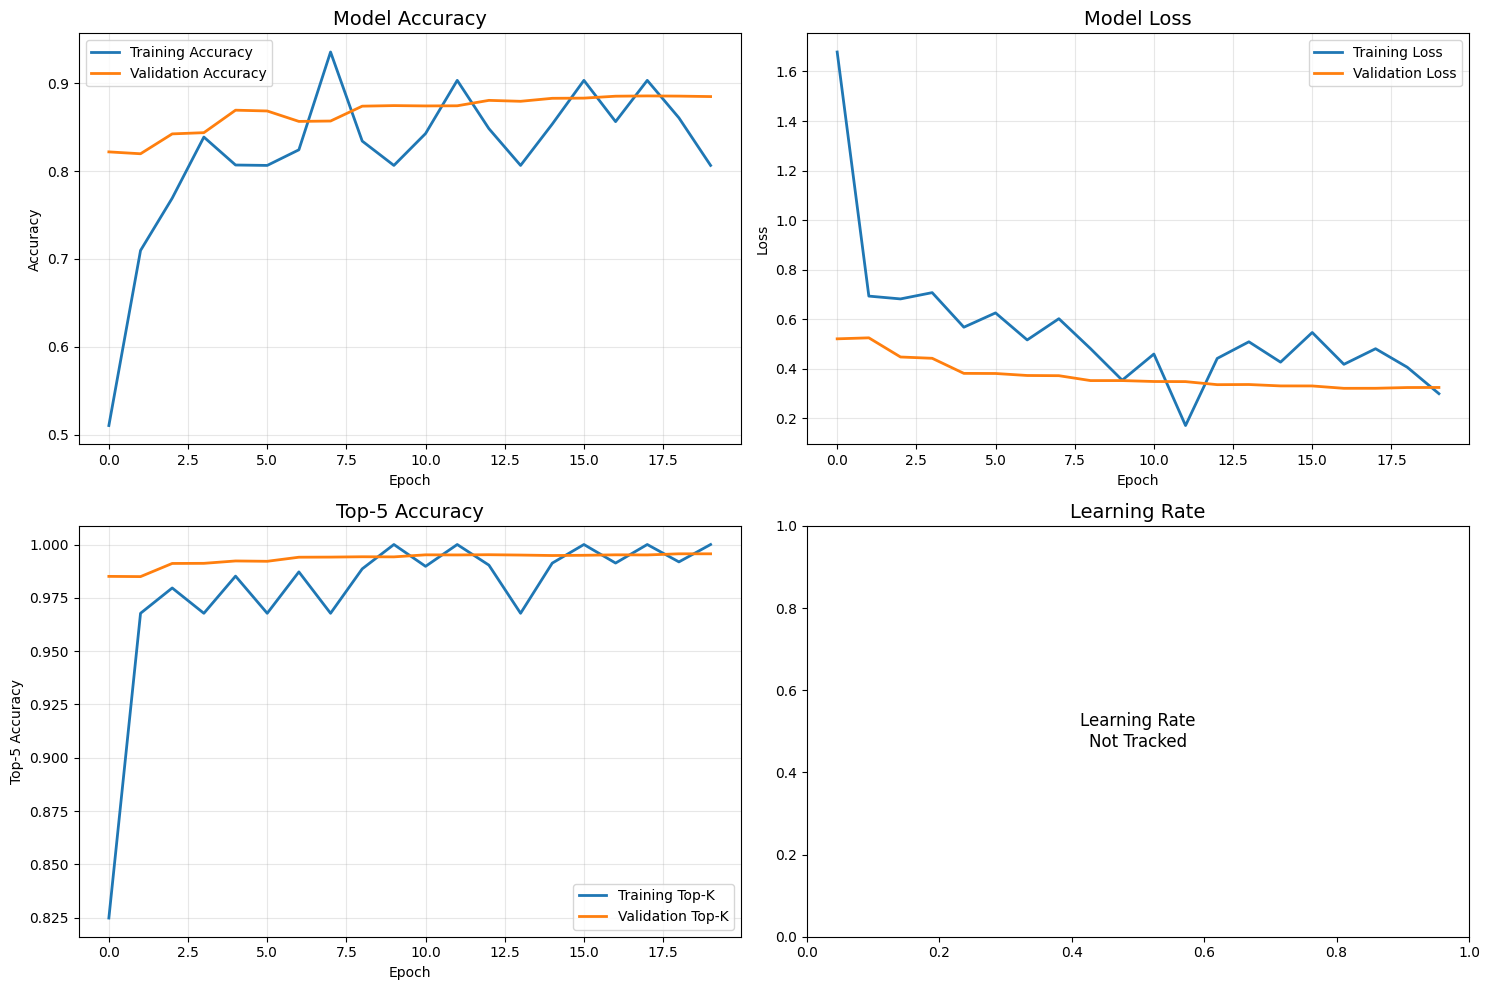

In [19]:
# Plot training history
def plot_training_history(history):
    """Plot training history"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Top-5 Accuracy
    axes[1, 0].plot(history.history['sparse_top_k_categorical_accuracy'], label='Training Top-K', linewidth=2)
    axes[1, 0].plot(history.history['val_sparse_top_k_categorical_accuracy'], label='Validation Top-K', linewidth=2)
    axes[1, 0].set_title('Top-5 Accuracy', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2)
        axes[1, 1].set_title('Learning Rate', fontsize=14)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Tracked',
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=12)
        axes[1, 1].set_title('Learning Rate', fontsize=14)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

=== Testing Model Predictions ===


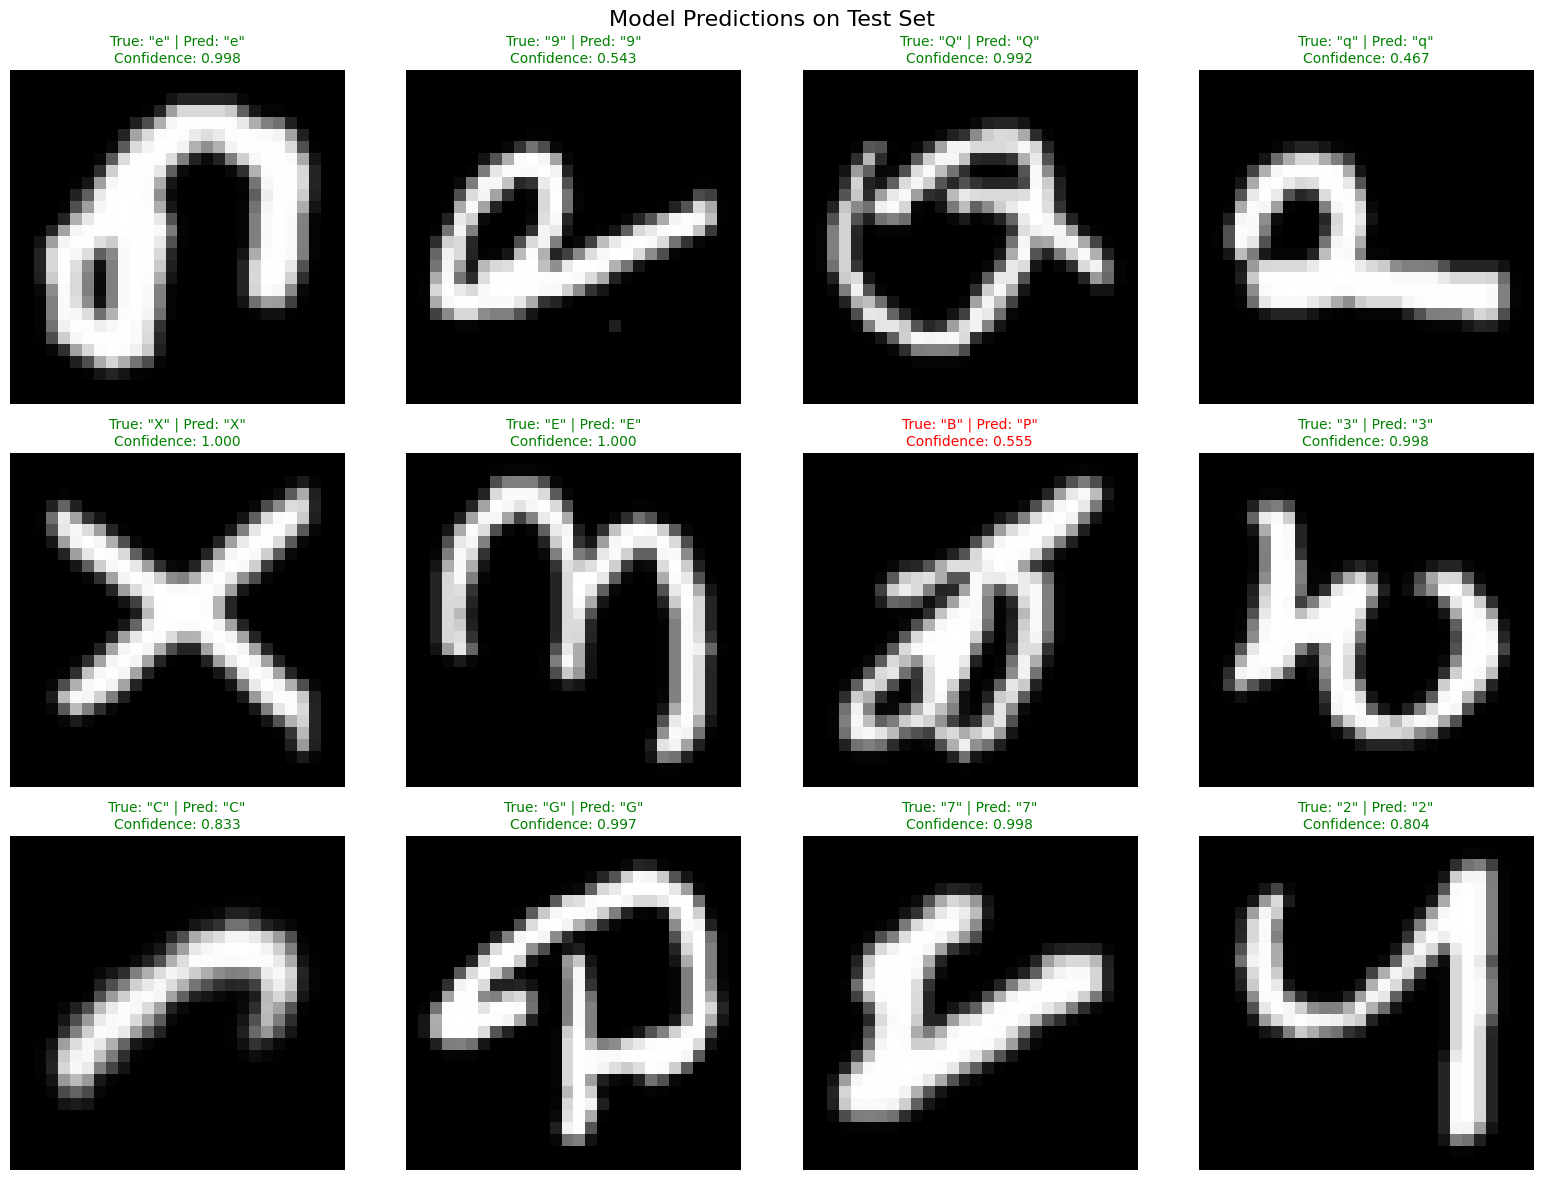

Batch accuracy: 0.917 (11/12)


In [20]:
# Test predictions and visualize results
def predict_and_visualize(model, test_dataset, label_to_char, n_samples=12):
    """Make predictions and visualize results"""

    # Get a batch of test data
    for images, true_labels in test_dataset.take(1):
        break

    # Make predictions
    predictions = model.predict(images[:n_samples], verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)

    # Plot results
    rows = 3
    cols = 4
    plt.figure(figsize=(16, 12))

    for i in range(min(n_samples, rows * cols)):
        plt.subplot(rows, cols, i + 1)

        # Display image
        image = images[i].numpy().squeeze()
        plt.imshow(image, cmap='gray')

        # Get true and predicted characters
        true_char = label_to_char[true_labels[i].numpy()]
        pred_char = label_to_char[predicted_classes[i]]
        confidence = confidence_scores[i]

        # Color code: green for correct, red for incorrect
        color = 'green' if true_labels[i].numpy() == predicted_classes[i] else 'red'

        plt.title(f'True: "{true_char}" | Pred: "{pred_char}"\nConfidence: {confidence:.3f}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle('Model Predictions on Test Set', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy for this batch
    correct = np.sum(true_labels[:n_samples].numpy() == predicted_classes)
    accuracy = correct / n_samples
    print(f"Batch accuracy: {accuracy:.3f} ({correct}/{n_samples})")

# Test predictions
print("=== Testing Model Predictions ===")
predict_and_visualize(model, test_dataset, label_to_char, n_samples=12)

In [18]:
# Evaluate the model
print("=== Model Evaluation ===")

# Evaluate on test set
test_loss, test_accuracy, test_top5_acc = model.evaluate(test_dataset, verbose=1)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-5 Accuracy: {test_top5_acc:.4f} ({test_top5_acc*100:.2f}%)")

# Save training history
history_path = '/content/drive/MyDrive/models/training_history.npy'
np.save(history_path, history.history)
print(f"Training history saved to: {history_path}")

=== Model Evaluation ===
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8848 - loss: 0.3264 - sparse_top_k_categorical_accuracy: 0.9947

Final Test Results:
Test Loss: 0.3216
Test Accuracy: 0.8852 (88.52%)
Test Top-5 Accuracy: 0.9952 (99.52%)
Training history saved to: /content/drive/MyDrive/models/training_history.npy


In [19]:
# Utility functions for single character prediction
def predict_single_character(model, image_array, label_to_char):
    """Predict single character from image array"""
    # Ensure proper shape and normalization
    if len(image_array.shape) == 2:
        image_array = image_array.reshape(28, 28, 1)
    elif len(image_array.shape) == 1:
        image_array = image_array.reshape(28, 28, 1)

    # Normalize if not already normalized
    if image_array.max() > 1.0:
        image_array = image_array.astype(np.float32) / 255.0

    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    prediction = model.predict(image_array, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    predicted_char = label_to_char[predicted_class]

    return predicted_class, predicted_char, confidence

# Test the function with some examples
print("=== Testing Single Character Prediction Function ===")

# Get some test images
for images, true_labels in test_dataset.take(1):
    break

# Test on first 3 images
for i in range(3):
    test_image = images[i].numpy().squeeze()
    true_label = true_labels[i].numpy()
    true_char = label_to_char[true_label]

    pred_label, pred_char, confidence = predict_single_character(model, test_image, label_to_char)

    print(f"Image {i+1}:")
    print(f"  True: {true_label} ('{true_char}')")
    print(f"  Predicted: {pred_label} ('{pred_char}')")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Correct: {'✓' if true_label == pred_label else '✗'}")
    print()

print("Single character prediction function working correctly!")

=== Testing Single Character Prediction Function ===
Image 1:
  True: 39 ('e')
  Predicted: 39 ('e')
  Confidence: 0.9977
  Correct: ✓

Image 2:
  True: 9 ('9')
  Predicted: 9 ('9')
  Confidence: 0.5417
  Correct: ✓

Image 3:
  True: 26 ('Q')
  Predicted: 26 ('Q')
  Confidence: 0.9921
  Correct: ✓

Single character prediction function working correctly!


In [ ]:
# Final summary and model saving
print("=== Final Summary ===")

# Model architecture summary
total_params = model.count_params()
print(f"Total model parameters: {total_params:,}")

# Training summary
# Access the dictionary within the loaded NumPy array
history_dict = history[()] # Use history[()] to access the scalar dictionary
best_val_acc = np.max(history_dict['val_accuracy'])
best_val_loss = np.min(history_dict['val_loss'])
best_epoch = np.argmin(history_dict['val_loss']) + 1

print(f"\nTraining Summary:")
print(f"Total epochs trained: {len(history_dict['accuracy'])}")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Final test top-5 accuracy: {test_top5_acc:.4f}")

# File sizes and paths
print(f"\nSaved Files:")
print(f"Best model: {model_save_path}")
print(f"Training history: {history_path}")

if os.path.exists(model_save_path):
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # MB
    print(f"Model file size: {model_size:.2f} MB")

print(f"\nDataset Summary:")
print(f"Training samples: {train_samples:,}")
print(f"Test samples: {test_samples:,}")
print(f"Number of classes: {num_classes}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH} pixels")


=== Final Summary ===
Total model parameters: 498,831

Training Summary:
Total epochs trained: 20
Best validation accuracy: 0.8855 at epoch 17
Best validation loss: 0.3216
Final test accuracy: 0.8852
Final test top-5 accuracy: 0.9952

Saved Files:
Best model: /content/drive/MyDrive/models/best_model.h5
Training history: /content/drive/MyDrive/models/training_history.npy

Dataset Summary:
Training samples: 112,799
Test samples: 18,799
Number of classes: 47
Image size: 28x28 pixels

🎉 EMNIST Handwritten Text Recognition Pipeline Completed Successfully! 🎉
